In [1]:
import numpy as np
import astropy.constants as const
import matplotlib.pyplot as plt

import rebound
import celmech
import gap_complexity_utils as gaps
from gap_complexity_utils import SimulationPair, EnsemblePair

In [2]:
from matplotlib import cm, colors, ticker
cmap = cm.magma
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'cmu-serif'

# OG/No OG Simulation Pairs

The following cells reproduce Figs. 2 and 3.

In [3]:
# rng_seed = np.random.randint(1, 1e10)
rng_seed = 4054033936

In [4]:
## Initialize a system with a 5-planet STIP
simpair = SimulationPair(5, simulation_time=100_000, rng_seed=rng_seed)
simpair.add(m=1.0e-3, a=10.0)

## Display simulation setup
# rebound.OrbitPlot(simpair.wout_og)
# rebound.OrbitPlot(simpair.with_og);

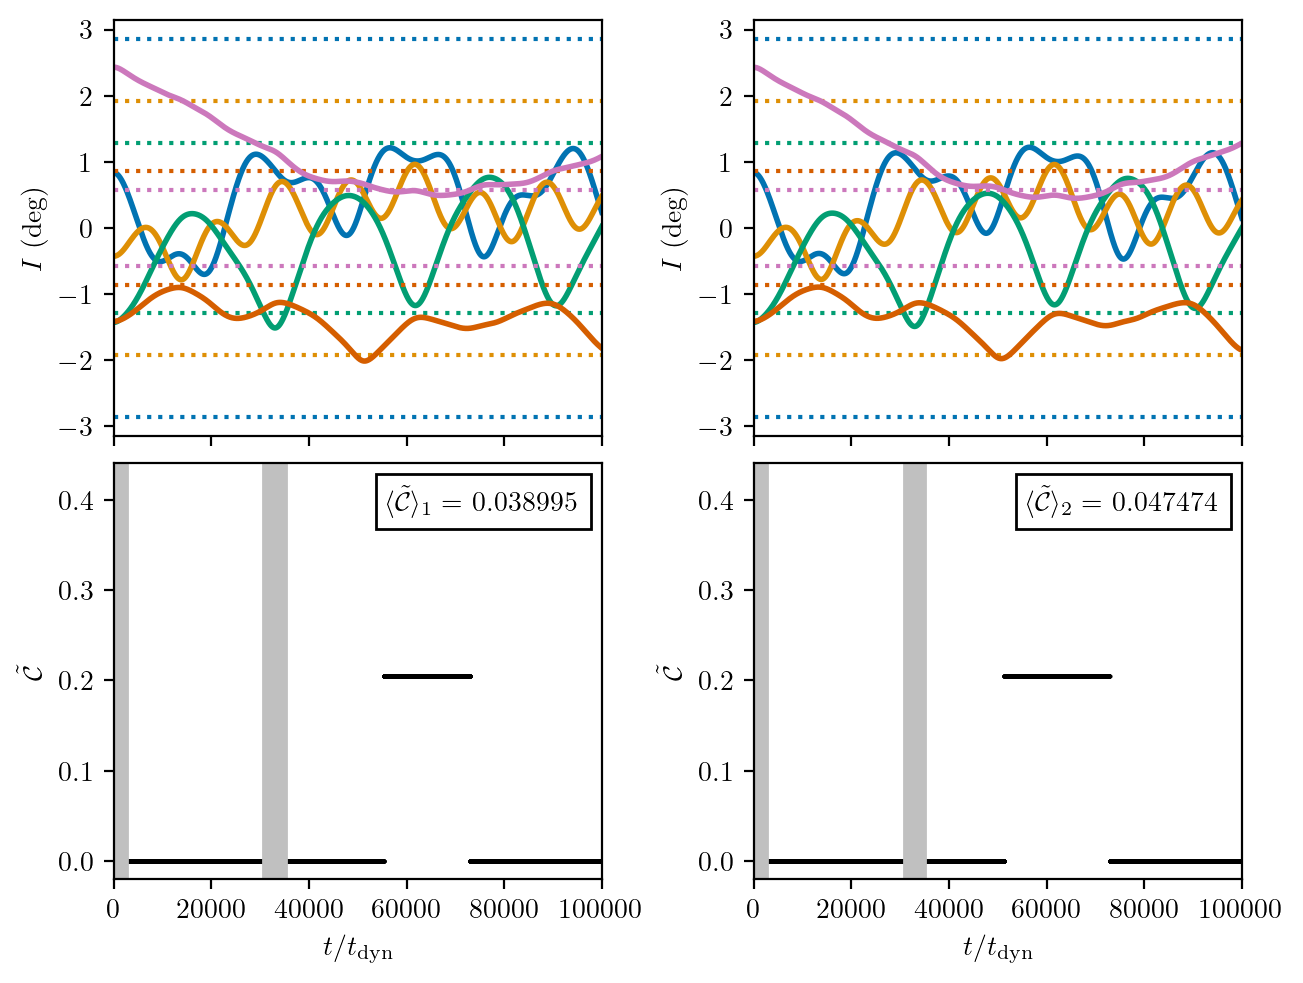

In [5]:
## Obtain gap complexity evolution
simpair.get_ll_systems()
simpair.get_ll_solutions()
simpair.get_gap_complexities()

## Plot results
# simpair.plot(save=True)
simpair.plot()

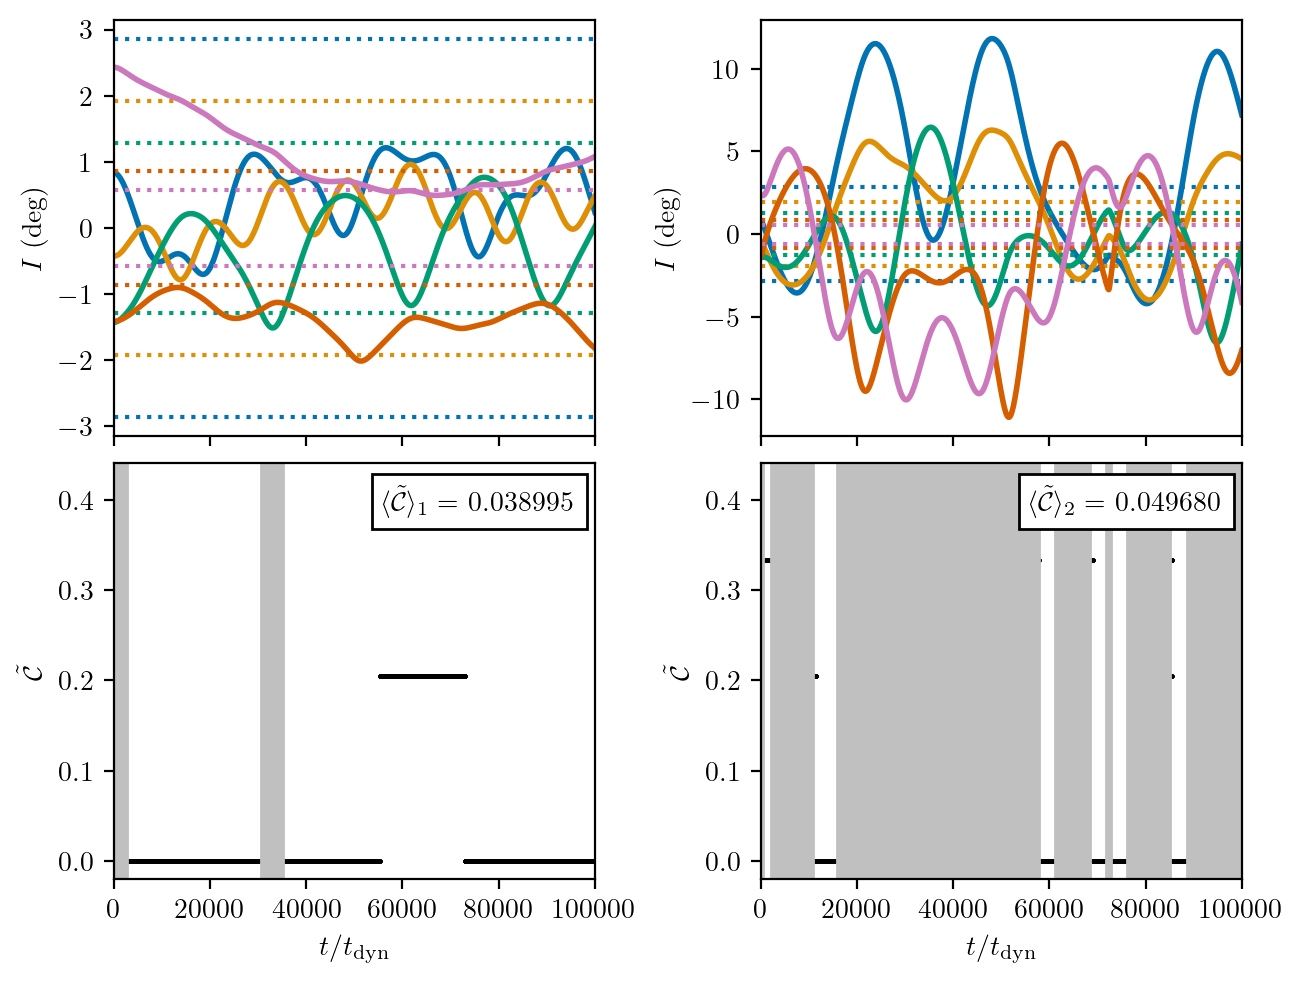

In [6]:
## Initialize new system
simpair = SimulationPair(5, simulation_time=100_000, rng_seed=rng_seed)
simpair.add(m=1.0e-2, a=2.0)

## Obtain gap complexity evolution
simpair.get_ll_systems()
simpair.get_ll_solutions()
simpair.get_gap_complexities()

## Plot results
# simpair.plot(save=True)
simpair.plot()

# Ensembles of OG/No OG Pairs

This demonstration shows how we might construct an ensemble of simulation pairs initialized with randomly selected OG masses and semi-major axes. Such a result is not presented in the paper, because statistics derived from any sample so constructed would be meaningless. This example does, however, provide an intuition for how the presence of an OG alters the character of these hypothetical systems at a population level.

In [7]:
my_ensemble = EnsemblePair(400, 4)
my_ensemble.set_og_mass_dist(np.random.uniform, 1.0e-3, 0.05)
my_ensemble.set_og_sma_dist(np.random.uniform, 0.75, 10.0)
my_ensemble.sample()

In [8]:
my_ensemble.run()

/Users/jrlivesey/Documents/GitHub/SecularGapComplexity/gap_complexity_utils.py:1233: RuntimeWarning: Mean of empty slice
  self.mean_gc_wout = np.nanmean(self.gc_wout)


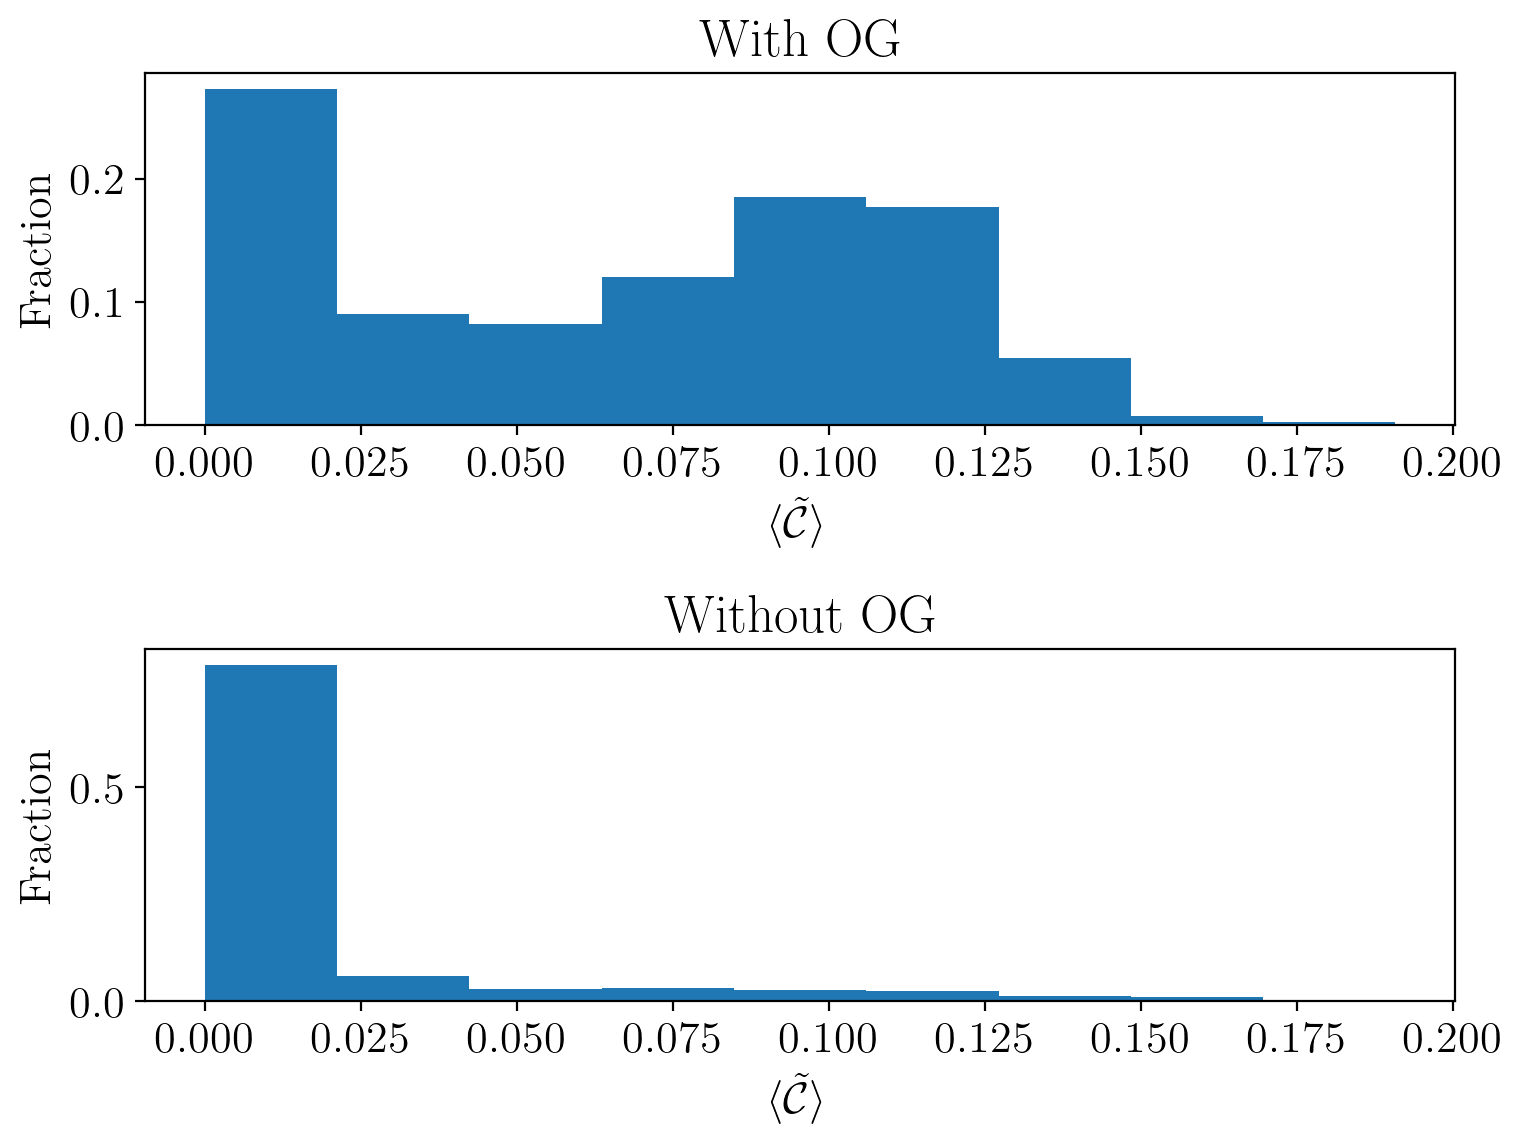

In [9]:
my_ensemble.histogram()

# Gap complexity as an observational metric

The gap complexity changes according to
$$
\mathcal{C} \propto -H D,
$$
where $H$ is the entropy (in the information theoretic sense) and $D$ is the disequilibrium. If we define $p_i^\star \equiv \log(P_N / P_i) / \log(P_{i+1} / P_i)$ for the $i$-th planet in an $N$-planet system, then
$$
H = \sum_{i=1}^{N-1} p_i^\star \log(p_i^\star) \quad \text{and} \quad D = \sum_{i=1}^{N-1} \left ( p_i^\star - \frac{1}{N - 1} \right )^2.
$$
The entropy and the disequilibrium are maximized for different sets of $p_i^\star$. To demonstrate this point, we construct a three-planet system and vary the orbital period of the second planet. Arbitrarily, we place the first planet at a 1-day orbit and the third at a $\mathrm{e}^2$-day orbit; the system is evenly logarithmically spaced when the second planet's period is $\mathrm{e}$ days, where $\mathrm{e}$ is Euler's constant.

In [10]:
def my_gap_complexity(period):
    periods_days = [1., period, np.exp(2.)]
    return gaps.gap_complexity(periods_days)

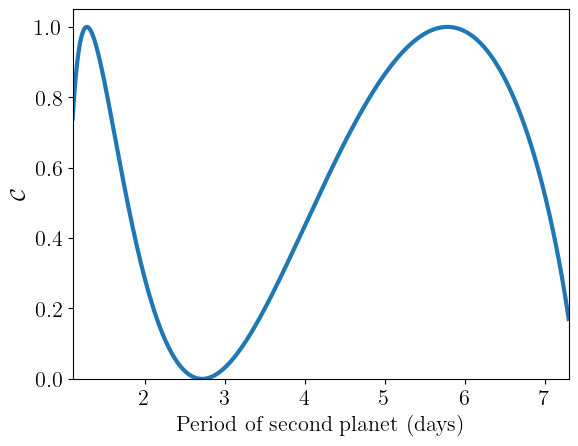

In [11]:
per = np.linspace(1.1, 7.3, 1_000)
gc = [my_gap_complexity(p) for p in per]

fig, ax = plt.subplots(1, 1)
ax.plot(per, gc, lw=3)
ax.set_xlim(1.1, 7.3)
ax.set_ylim(bottom=0.)
ax.set_xlabel('Period of second planet (days)')
ax.set_ylabel(r'$\mathcal{C}$');

The gap complexity is minimized at 10 days, as we expected, and does not exist where planets overlap, because then there is only one gap in the system.

Consider a system of $N = 8$ planets with perfectly regular spacing; i.e., a true value of $\mathcal{C} = 0$. If only a few planets are transiting, the number of planets we see and which they are will influence the gap complexity that we measure. We will leave the innermost and outermost planet, and randomly remove the other planets one-by-one. The periods here are in arbitrary units.

In [12]:
def plot_complexity_with_multiplicity(rng_seed=None):
    rng = np.random.default_rng(rng_seed)
    
    mult = [8, 7, 6, 5, 4, 3]
    pers = [np.exp(n) for n in range(8)]
    gc = np.empty(6)
    
    gc[0] = gaps.gap_complexity(pers)
    for i in range(5):
        rand_idx = rng.integers(1, len(pers) - 2) + 1
        pers.remove(pers[rand_idx])
        gc[i+1] = gaps.gap_complexity(pers)
    
    fig, ax = plt.subplots(1, 1)
    ax.scatter(mult, gc)
    ax.set_ylim(bottom=0.)
    ax.set_xlabel('Number of observed planets')
    ax.set_ylabel('$\mathcal{C}$')
    ax.invert_xaxis()
    return

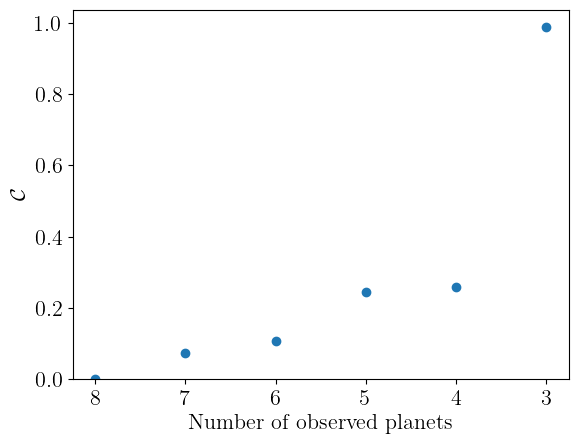

In [13]:
plot_complexity_with_multiplicity()

The behavior here depends on which planets are removed from the system (do not transit), so running the above cell over again will produce a different result. Broadly speaking, the complexity increases as we remove observable planets.

# The OG/SC discrepancy under secular theory

Why might the gap complexity respond to the presence of OGs more than to SCs? SCs are both more massive and more distant than OGs, in general. Switching from one to the other, the change enters the calculation through the secular matrix ($\bf{B}$). Holding the properties of some STIP planet constant, the corresponding elements of the secular matrix are all
$$
B_{jj} \propto B_{jk} \propto m_k \alpha_{jk} \bar{\alpha}_{jk} b^{(1)}_{3/2}(\alpha_{jk}),
$$
where $m_k$ is the outer companion mass and each of $\alpha_{jk}$,
$$
\bar{\alpha}_{jk} = \begin{cases} \alpha_{jk}, & \alpha_{jk} < 1 \\ 1, & \alpha_{jk} \geq 1 \end{cases},
$$
and the Laplace coefficient $b^{(1)}_{3/2}(\alpha_{jk})$ are pure functions of the semi-major axis.

In [14]:
from pylaplace import LaplaceCoefficient
coeff = LaplaceCoefficient()
def laplace_coefficient(ratio):
    return coeff(ratio, 1.5, 1., 1., 1.)

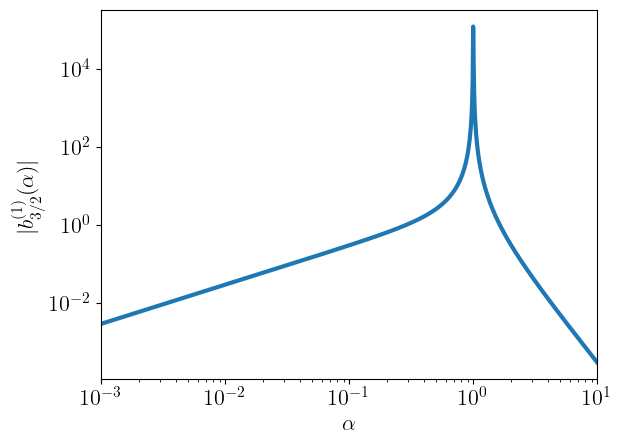

In [15]:
ain = np.logspace(-3.0, 1.0, 1000)
bb = np.array([laplace_coefficient(a) for a in ain])

plt.loglog(ain, np.abs(bb), lw=3)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$|b^{(1)}_{3/2}(\alpha)|$')
plt.xlim(ain.min(), ain.max());

In [16]:
def the_function(mass, alpha):
    alpha_bar = 0.0; b = 0.0
    if type(alpha) == np.ndarray:
        if alpha.any() > 1.0:
            alpha_bar = np.ones_like(alpha)
        else:
            alpha_bar = alpha
        b = np.empty(alpha.shape)
        for i in range(len(alpha[0])):
            for j in range(len(alpha[1])):
                b[i, j] = laplace_coefficient(alpha[i, j])
    else:
        if alpha > 1.0:
            alpha_bar = 1.0
        else:
            alpha_bar = alpha
        b = laplace_coefficient(alpha)
    return np.abs(mass * alpha * alpha_bar * b)

In [17]:
## Data for KGPS systems with 3+ STIP planets from Weiss+ 2023
## m_star in solar masses, m_og in Earth masses, distances in au

system_list = [
    # KOI-85 -- 3 TIP, 1 OG
    {'name': 'Kepler-65', 'm_star': 1.24, 'm_og': 217.0, 'alpha': 0.85 / 0.085},

    # KOI-316 -- 3 TIP, 1 OG
    {'name': 'Kepler-139', 'm_star': 1.08, 'm_og': 430.0, 'alpha': 3.2 / 0.58},

    # KOI-148 -- 3 TIP, 2 OG
    {'name': 'Kepler-48', 'm_star': 0.91, 'm_og': 687.0, 'alpha': 1.9 / 0.23},

    # KOI-351 -- 7 TIP, 1 OG
    {'name': 'Kepler-90', 'm_star': 1.11, 'm_og': 236.0, 'alpha': 0.97 / 0.72},

    # KOI-2169 -- 4 TIP, SC
    {'name': 'Kepler-1130', 'm_star': 0.94, 'm_og': 7.047e+4, 'alpha': 12.0 / 0.06},

    # KOI-3158 -- 5 TIP, SC
    {'name': 'Kepler-444', 'm_star': 0.73, 'm_og': 2.0e+5, 'alpha': 52.2 / 0.078},
]

In [18]:
og_systems = system_list[0:4]
sc_systems = system_list[4:]

og_mean_alpha = np.mean([sys['alpha'] for sys in og_systems])
sc_mean_alpha = np.mean([sys['alpha'] for sys in sc_systems])
og_mean_rel_mass = np.mean(
    [sys['m_og'] / sys['m_star'] * const.M_earth / const.M_sun for sys in og_systems]
)
sc_mean_rel_mass = np.mean(
    [sys['m_og'] / sys['m_star'] * const.M_earth / const.M_sun for sys in sc_systems]
)

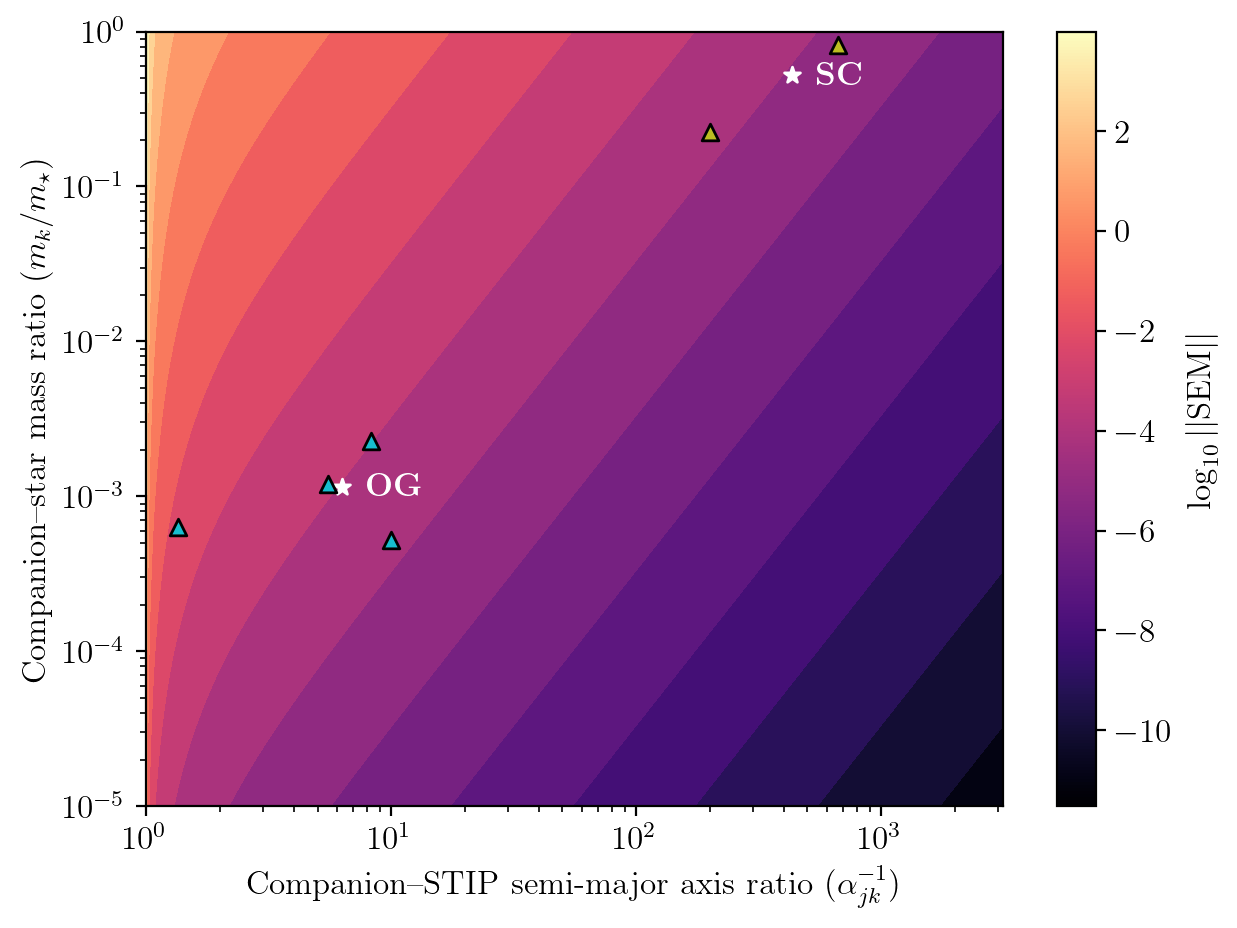

In [19]:
mm = np.logspace(-5.0, 0.0, 1000)
# aa = np.logspace(-3.5, 0.1, 1000) # "alpha"
aa = np.logspace(-0.0, 3.5, 1000) # "inverse alpha"

_a, _m = np.meshgrid(aa, mm)
prod = the_function(_m, _a)

plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(1, 1, dpi=200)
ax.contourf(_a, _m, prod, locator=ticker.LogLocator(numticks=100), cmap=cmap)
cb = plt.colorbar(cm.ScalarMappable(
        norm=colors.Normalize(
            vmin=np.log10(np.nanmin(prod)),
            vmax=np.log10(np.nanmax(prod[prod != np.inf])),
        ),
        cmap=cmap,
    ),
    ax=ax,
)
# ax.set_xlim(right=1.0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Companion--STIP semi-major axis ratio $(\alpha_{jk}^{-1})$')
ax.set_ylabel(r'Companion--star mass ratio $(m_k / m_\star)$')
# cb.set_label(r'$\log_{10} \left | (m_k / m_\star) \alpha_{jk} \bar{\alpha}_{jk} b^{(1)}_{3/2}(\alpha_{jk}) \right |$')
cb.set_label(r'$\log_{10}||\mathrm{SEM}||$')

# ax.scatter(10., 0.001, c='w', marker='*')
# ax.text(12., 0.001, r'\bf{OG}', c='w')

# ax.scatter(1000., 0.1, c='w', marker='*')
# ax.text(550., 0.1, r'\bf{SC}', c='w')

ax.scatter(og_mean_alpha, og_mean_rel_mass, c='w', marker='*')
ax.text(8., 0.001, r'\bf{OG}', c='w')

ax.scatter(sc_mean_alpha, sc_mean_rel_mass, c='w', marker='*')
ax.text(550., 0.45, r'\bf{SC}', c='w')

for system in system_list:
    rel_mass = system['m_og'] / system['m_star'] * const.M_earth / const.M_sun
    alpha = 1.0 / system['alpha'] # "alpha"
    alpha = system['alpha'] # "inverse alpha"
    color = 'tab:cyan'
    if rel_mass > 1.0e-2:
        color = 'tab:olive'
    ax.scatter(alpha, rel_mass, c=color, marker='^', edgecolors='k')

fig.tight_layout()
# fig.savefig('secular-matrix-scaling.pdf')
# fig.savefig('secular-matrix-scaling.png');

In [20]:
scaling = the_function(og_mean_rel_mass, og_mean_alpha) / the_function(sc_mean_rel_mass, sc_mean_alpha)
print(f'On average, the scaling factor is %f times greater for OG systems than for SC systems.' % scaling)

On average, the scaling factor is 767.378187 times greater for OG systems than for SC systems.
